In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb 
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU, Conv1D, MaxPooling1D, Input, concatenate
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

## 1. Reading the data files

In [4]:
train = pd.read_pickle('features.pkl')
predict = pd.read_csv('/content/drive/MyDrive/Final Project/Train.csv')

## 2. Set up training and testing sets

In [6]:
feature_cols = ['sum','mean','elevation','poly_rainfall','poly_elevation',
                'elev_diff','rainfall_diff','water_count','water_dist']
features = train[feature_cols]
target = train['target']

In [7]:
# train-test split (80-20)
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

## 3. Define loss function

In [8]:
def rmse(y_true,y_pred):
    return np.sqrt(mse(y_true,y_pred))

## 4a. Prediction using Lasso regression

In [21]:
# Lasso regression
best_lasso_model = None
best_lasso_score = float('inf')
best_alpha = 0
for a in tqdm(range(0,100)):
    lasso_model = Lasso(alpha=a/10).fit(x_train, y_train)
    val_pred_lasso = lasso_model.predict(x_val)
    val_score_lasso = rmse(val_pred_lasso,y_val)
    if val_score_lasso < best_lasso_score:
        best_alpha = a
        best_lasso_score = val_score_lasso
        best_lasso_model = lasso_model
print(f'RMSE for lasso: {best_lasso_score}, alpha = {best_alpha}')

100%|██████████| 100/100 [00:02<00:00, 37.44it/s]

RMSE for lasso: 0.21830691185854453, alpha = 0


## 4b. Prediction using Ridge regression

In [22]:
# Ridge regression
best_ridge_model = None
best_ridge_score = float('inf')
best_alpha = 1
for a in tqdm(range(0,100)):
    ridge_model = Ridge(alpha=a/10).fit(x_train,y_train)
    val_pred_ridge = ridge_model.predict(x_val)
    val_score_ridge = rmse(val_pred_ridge,y_val)
    if val_score_ridge < best_ridge_score:
        best_alpha = a
        best_ridge_score = val_score_ridge
        best_ridge_model = ridge_model
print(f'RMSE for ridge: {best_ridge_score}, alpha = {best_alpha}')

100%|██████████| 100/100 [00:01<00:00, 78.11it/s]

RMSE for ridge: 0.21830698469763316, alpha = 1


## 4c. Prediction using Random Forests

In [23]:
# RandomForest 
rf_model = RandomForestRegressor(n_estimators = 500,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                max_samples = 0.8
                                )
rf_model.fit(x_train,y_train)
val_pred_rf = rf_model.predict(x_val)
val_score_rf = rmse(val_pred_rf,y_val)
print(f'RMSE for Random Forest: {val_score_rf}')

RMSE for Random Forest: 0.12318053048520272


## 4d. Prediction using LGBM

In [26]:
# LGBM
lgb_params = {
        'boosting_type': 'gbdt',         
        'objective': 'regression',       
        'metric': ['rmse'],             
        'subsample': 0.5,                
        'subsample_freq': 1,
        'learning_rate': 0.05,           
        'num_leaves': 2**8,            
        'min_data_in_leaf': 2**4,      
        'feature_fraction': 0.5,
        'n_estimators': 5000,            
        'early_stopping_rounds': 30,     
        'verbose': -1,
            } 
train_set = lgb.Dataset(x_train, y_train)
val_set = lgb.Dataset(x_val, y_val)
lgb_model = lgb.train(lgb_params, train_set, num_boost_round = 2000, valid_sets = [train_set, val_set], verbose_eval = 100)

Training until validation scores don't improve for 30 rounds.
[100]	training's rmse: 0.104317	valid_1's rmse: 0.118665
[200]	training's rmse: 0.0981742	valid_1's rmse: 0.117294
Early stopping, best iteration is:
[209]	training's rmse: 0.0979237	valid_1's rmse: 0.117245


## 4e. Prediction using deep neural network

In [27]:
# training configurations
from keras import backend as K

def keras_rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
num_epochs = 100
batch_size = 4
num_nodes = 256
num_layers = 3
dropout = 0.2
loss_fn = keras_rmse
optimizer = 'adagrad'

In [29]:
# MLP
mlp_model = Sequential()
mlp_model.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='sigmoid'))
mlp_model.add(Dropout(dropout))

for i in range(num_layers-1):
    mlp_model.add(Dense(num_nodes, activation='sigmoid'))
    mlp_model.add(Dropout(dropout))
mlp_model.add(Dense(1, activation='sigmoid'))
mlp_model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('mlp_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
mlp_model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=num_epochs,
                validation_data=(x_val, y_val),
                callbacks=[es,mc],
                verbose=1)

Epoch 1/100
3283/3293 [============================>.] - ETA: 0s - loss: 0.1478 - accuracy: 0.8321
Epoch 1: val_accuracy improved from -inf to 0.83182, saving model to mlp_best_model.h5
3293/3293 [==============================] - 10s 3ms/step - loss: 0.1477 - accuracy: 0.8321 - val_loss: 0.1390 - val_accuracy: 0.8318
Epoch 2/100
3280/3293 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.8318
Epoch 2: val_accuracy did not improve from 0.83182
3293/3293 [==============================] - 8s 2ms/step - loss: 0.1414 - accuracy: 0.8321 - val_loss: 0.1383 - val_accuracy: 0.8318
Epoch 3/100
3286/3293 [============================>.] - ETA: 0s - loss: 0.1406 - accuracy: 0.8322
Epoch 3: val_accuracy did not improve from 0.83182
3293/3293 [==============================] - 9s 3ms/step - loss: 0.1405 - accuracy: 0.8321 - val_loss: 0.1381 - val_accuracy: 0.8318
Epoch 4/100
3288/3293 [============================>.] - ETA: 0s - loss: 0.1384 - accuracy: 0.8320
Epoch 4: val_ac

## 4f. Prediction using a stacking ensemble

In [30]:
# stacking ensemble

# creating stacked dataset
lasso_pred = best_lasso_model.predict(x_val)
ridge_pred = best_ridge_model.predict(x_val)
rf_pred = rf_model.predict(x_val)
lgb_pred = lgb_model.predict(x_val)
mlp_pred = mlp_model.predict(x_val)
mlp_pred = mlp_pred.reshape(mlp_pred.shape[0])
preds = [lasso_pred, ridge_pred, rf_pred, lgb_pred, mlp_pred]
stacked_X = None
for pred in preds:
    if stacked_X is None:
        stacked_X = pred
    else:
        stacked_X = np.dstack((stacked_X, pred))

stacked_X = stacked_X.reshape(stacked_X.shape[1],stacked_X.shape[2])

In [35]:
# train-test split
cut = stacked_X.shape[0]//5
stacked_x_val = stacked_X[:cut]
stacked_x_train = stacked_X[cut:]
stacked_y_val = y_val[:cut]
stacked_y_train = y_val[cut:]

In [36]:
# use MLP for stacking ensemble
model = Sequential()
model.add(Dense(num_nodes, input_dim=stacked_x_train.shape[1], activation='sigmoid'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=keras_rmse, optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('ensemble_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=model.fit(stacked_x_train, stacked_y_train,
                batch_size=batch_size,
                epochs=100,
                validation_data=(stacked_x_val, stacked_y_val),
               callbacks=[es,mc],
                 verbose=1)
# score, accuracy = model.evaluate(stacked_x_test, stacked_y_test,batch_size=batch_size)
# # print(f'Test score: {score}')
# print(f'Final test accuracy: {accuracy}')

Epoch 1/100
632/659 [===========================>..] - ETA: 0s - loss: 0.1483 - accuracy: 0.8307
Epoch 1: val_accuracy improved from -inf to 0.82371, saving model to ensemble_best_model.h5
659/659 [==============================] - 2s 2ms/step - loss: 0.1475 - accuracy: 0.8312 - val_loss: 0.1368 - val_accuracy: 0.8237
Epoch 2/100
637/659 [===========================>..] - ETA: 0s - loss: 0.1383 - accuracy: 0.8324
Epoch 2: val_accuracy did not improve from 0.82371
659/659 [==============================] - 1s 2ms/step - loss: 0.1380 - accuracy: 0.8338 - val_loss: 0.1365 - val_accuracy: 0.8237
Epoch 3/100
638/659 [============================>.] - ETA: 0s - loss: 0.1410 - accuracy: 0.8362
Epoch 3: val_accuracy did not improve from 0.82371
659/659 [==============================] - 1s 2ms/step - loss: 0.1411 - accuracy: 0.8338 - val_loss: 0.1364 - val_accuracy: 0.8237
Epoch 4/100
656/659 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.8403
Epoch 4: val_accuracy imp

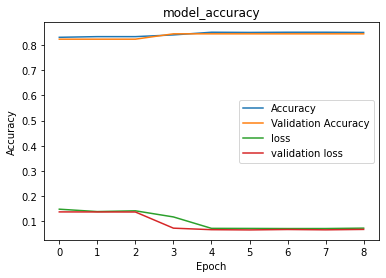

In [45]:
hist = history
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("model_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","validation loss"])
plt.show()